In [1]:
!pip install prophet

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.0.1 -> 25.2
[notice] To update, run: pip install --upgrade pip


In [2]:
from prophet import Prophet
import pandas as pd

In [3]:
data = {
    'ds': pd.to_datetime([
        '2023-04-01', '2023-04-02', '2023-04-03', '2023-04-04', '2023-04-05',
        '2023-04-06', '2023-04-07', '2023-04-08', '2023-04-09', '2023-04-10',
        '2023-04-11', '2023-04-12', '2023-04-13', '2023-04-14', '2023-04-15',
        '2023-04-16', '2023-04-17', '2023-04-18', '2023-04-19', '2023-04-20'
    ]),
    'y': [
        120, 90, 85, 88, 92,
        95, 125, 130, 95, 80,
        80, 250, 320, 280, 150, # ช่วงสงกรานต์ที่คุณยกตัวอย่าง
        90, 85, 88, 91, 94
    ]
}
df = pd.DataFrame(data)

# แสดงข้อมูล 5 แถวแรก
print(df.head())

          ds    y
0 2023-04-01  120
1 2023-04-02   90
2 2023-04-03   85
3 2023-04-04   88
4 2023-04-05   92


In [4]:
holidays = pd.DataFrame({
  'holiday': 'songkran',
  'ds': pd.to_datetime(['2023-04-13']),
  'lower_window': -2,  # ให้เริ่มมีผลกระทบ 2 วันก่อนวันจริง (คือวันที่ 11, 12)
  'upper_window': 1,   # และให้มีผลกระทบต่อไปอีก 1 วันหลังวันจริง (คือวันที่ 14)
})

print(holidays)

    holiday         ds  lower_window  upper_window
0  songkran 2023-04-13            -2             1


In [5]:
model = Prophet(holidays=holidays, weekly_seasonality=True, yearly_seasonality=False)

# สอน Model ด้วยข้อมูลของเรา
model.fit(df)

08:50:43 - cmdstanpy - INFO - Chain [1] start processing
08:50:44 - cmdstanpy - INFO - Chain [1] done processing


In [6]:
future = model.make_future_dataframe(periods=10)

# พยากรณ์
forecast = model.predict(future)

# yhat คือค่าพยากรณ์หลัก
# yhat_lower และ yhat_upper คือช่วงความไม่แน่นอน

print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())

           ds        yhat  yhat_lower  yhat_upper
25 2023-04-26   83.633438   78.448660   89.083739
26 2023-04-27   85.669056   79.888203   91.574917
27 2023-04-28  114.160657  108.569832  119.704796
28 2023-04-29  120.573018  114.445554  126.655297
29 2023-04-30   77.619273   71.391610   84.128945


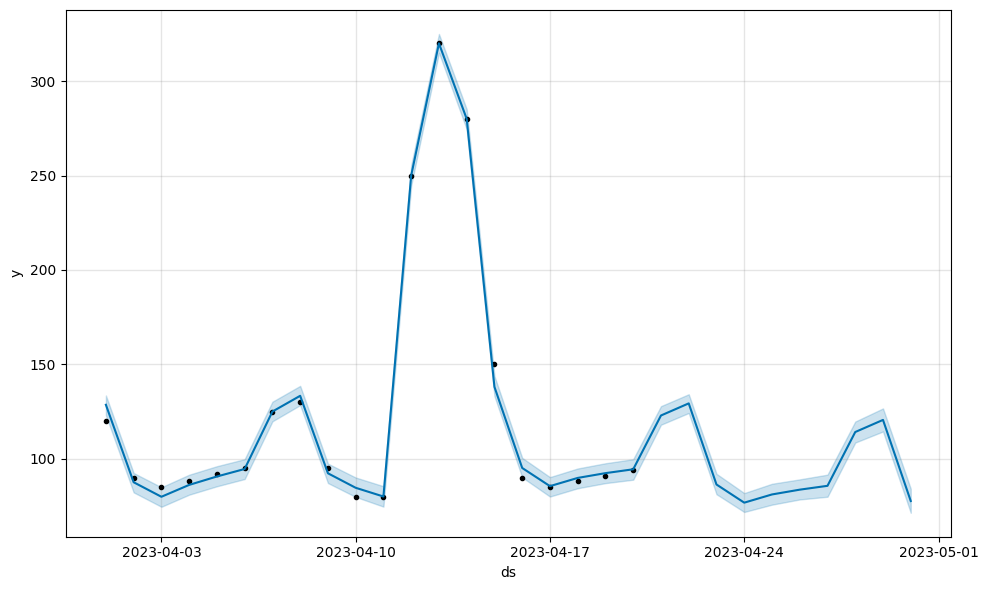

In [7]:
fig1 = model.plot(forecast)

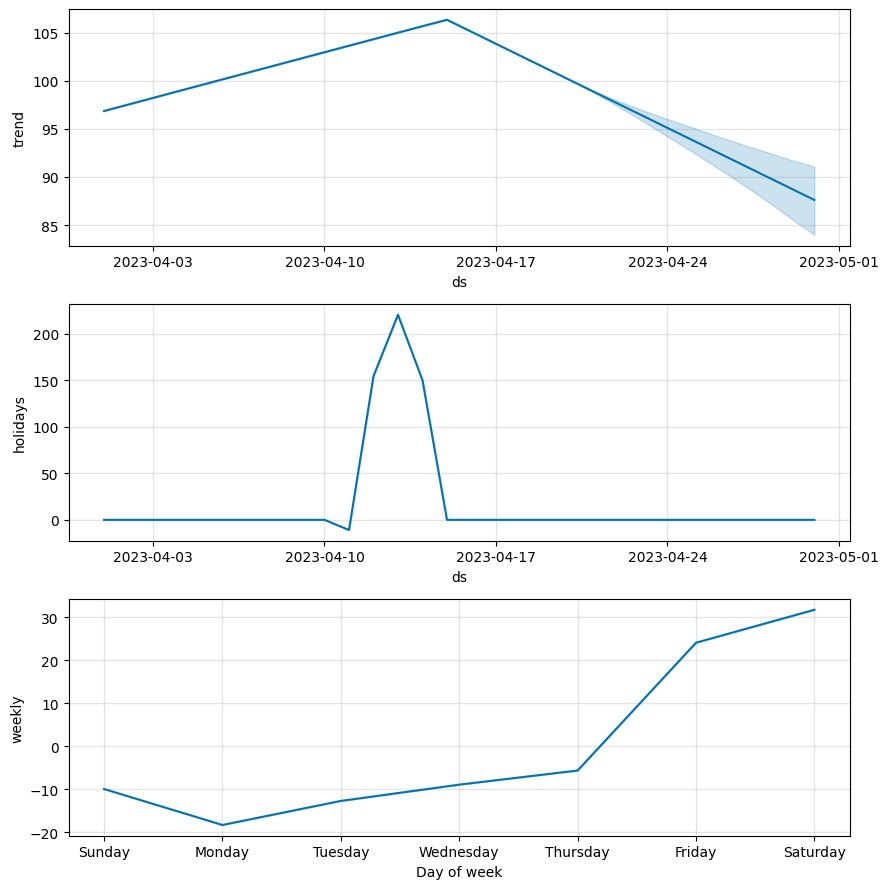

In [8]:
fig2 = model.plot_components(forecast)

In [9]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns

In [10]:
date_rng = pd.date_range(start='2023-01-01', end='2024-12-31', freq='D')
df = pd.DataFrame(date_rng, columns=['date'])

In [11]:
np.random.seed(42) # เพื่อให้ผลลัพธ์เหมือนกันทุกครั้ง
noise = np.random.randint(0, 15, size=(len(df)))

In [12]:
weekday_effect = df['date'].dt.dayofweek.apply(lambda x: 25 if x >= 5 else 0) # 5=เสาร์, 6=อาทิตย์

In [13]:
time_trend = np.arange(len(df)) * 0.1

In [14]:
df['patients'] = 80 + weekday_effect + time_trend + noise

In [15]:
df.set_index('date', inplace=True)

df.head()

,patients
date,
2023-01-01,111.0
2023-01-02,83.1
2023-01-03,92.2
2023-01-04,94.3
2023-01-05,90.4


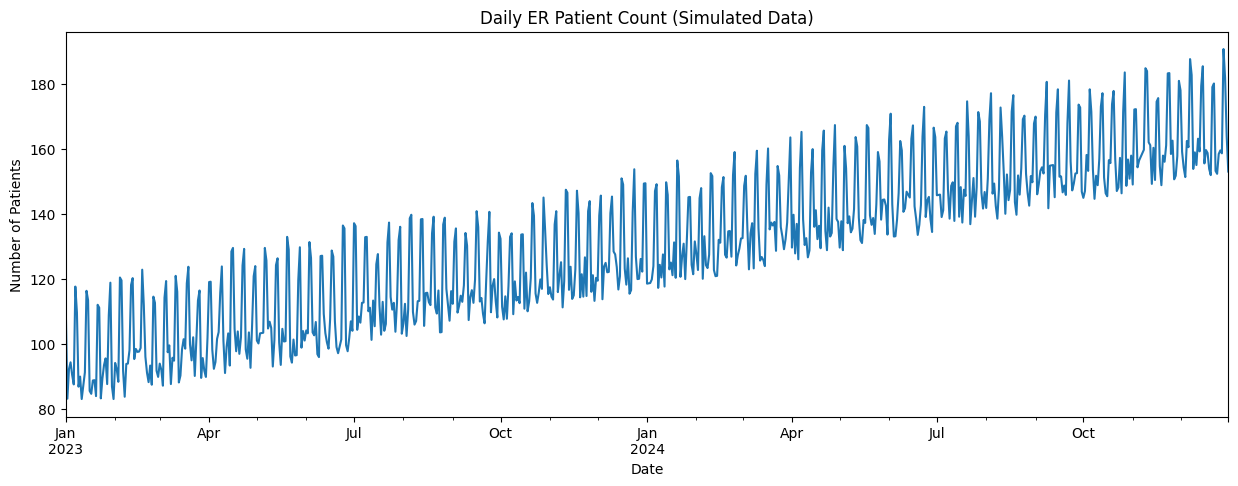

In [16]:
df['patients'].plot(figsize=(15, 5), title='Daily ER Patient Count (Simulated Data)')
plt.xlabel('Date')
plt.ylabel('Number of Patients')
plt.show()

In [17]:
def create_features(df):
    # สร้าง features จาก date

    df['dayofweek'] = df.index.dayofweek # 0 = จันทร์, 6 = อาทิตย์
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['dayofyear'] = df.index.dayofyear

    # สร้าง Lag Features (ข้อมูลย้อนหลัง)
    # เราจะใช้ข้อมูล 7 วันที่แล้ว และ 14 วันที่แล้วมาช่วยทาย
    df['lag_7'] = df['patients'].shift(7)
    df['lag_14'] = df['patients'].shift(14)

    # สร้าง ค่าเฉลี่ยย้อนหลัง
    df['rolling_mean_7'] = df['patients'].shift(1).rolling(window=7).mean()

    return df

df = create_features(df)

# ข้อมูลจะมีค่าว่าง (NaN) ในช่วงแรกๆ เพราะยังไม่มีข้อมูลย้อนหลังให้คำนวณ
# เราจะลบแถวที่มีค่าว่างทิ้งไป
df.dropna(inplace=True)

df.head()

,patients,dayofweek,quarter,month,dayofyear,lag_7,lag_14,rolling_mean_7
date,,,,,,,,
2023-01-15,113.4,6,1,1,15,109.7,111.0,94.857143
2023-01-16,85.5,0,1,1,16,86.8,83.1,95.385714
2023-01-17,84.6,1,1,1,17,89.9,92.2,95.200000
2023-01-18,88.7,2,1,1,18,83.0,94.3,94.442857
2023-01-19,88.8,3,1,1,19,87.1,90.4,95.257143


In [18]:
FEATURES = ['dayofweek', 'quarter', 'month', 'dayofyear', 'lag_7', 'lag_14', 'rolling_mean_7']
TARGET = 'patients'

In [19]:
X = df[FEATURES]
y = df[TARGET]

In [20]:
split_date = '2024-10-01'
X_train, X_test = X.loc[X.index < split_date], X.loc[X.index >= split_date]
y_train, y_test = y.loc[y.index < split_date], y.loc[y.index >= split_date]

In [21]:
print(f"Train set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

Train set: 625 samples
Test set: 92 samples


In [22]:
# Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [23]:
# XGBoost
xgb_model = xgb.XGBRegressor(n_estimators=100,
                             learning_rate=0.05, # ค่อยๆ เรียนรู้ช้าๆ
                             early_stopping_rounds=10, # ถ้าผลไม่ดีขึ้น 10 รอบให้หยุด
                             random_state=42)

In [24]:
# XGBoost ต้องมี evaluation set เพื่อใช้ early stopping
xgb_model.fit(X_train, y_train,
              eval_set=[(X_test, y_test)],
              verbose=False)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=10,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [25]:
rf_pred = rf_model.predict(X_test)
xgb_pred = xgb_model.predict(X_test)

In [26]:
rf_mae = mean_absolute_error(y_test, rf_pred)
xgb_mae = mean_absolute_error(y_test, xgb_pred)

In [27]:
print(f"\nความคลาดเคลื่อนเฉลี่ยของ Random Forest: {rf_mae:.2f} คน")
print(f"ความคลาดเคลื่อนเฉลี่ยของ XGBoost: {xgb_mae:.2f} คน")


ความคลาดเคลื่อนเฉลี่ยของ Random Forest: 5.54 คน
ความคลาดเคลื่อนเฉลี่ยของ XGBoost: 6.59 คน


In [28]:
results = pd.DataFrame({
    'Actual': y_test,
    'Random Forest': rf_pred,
    'XGBoost': xgb_pred
})

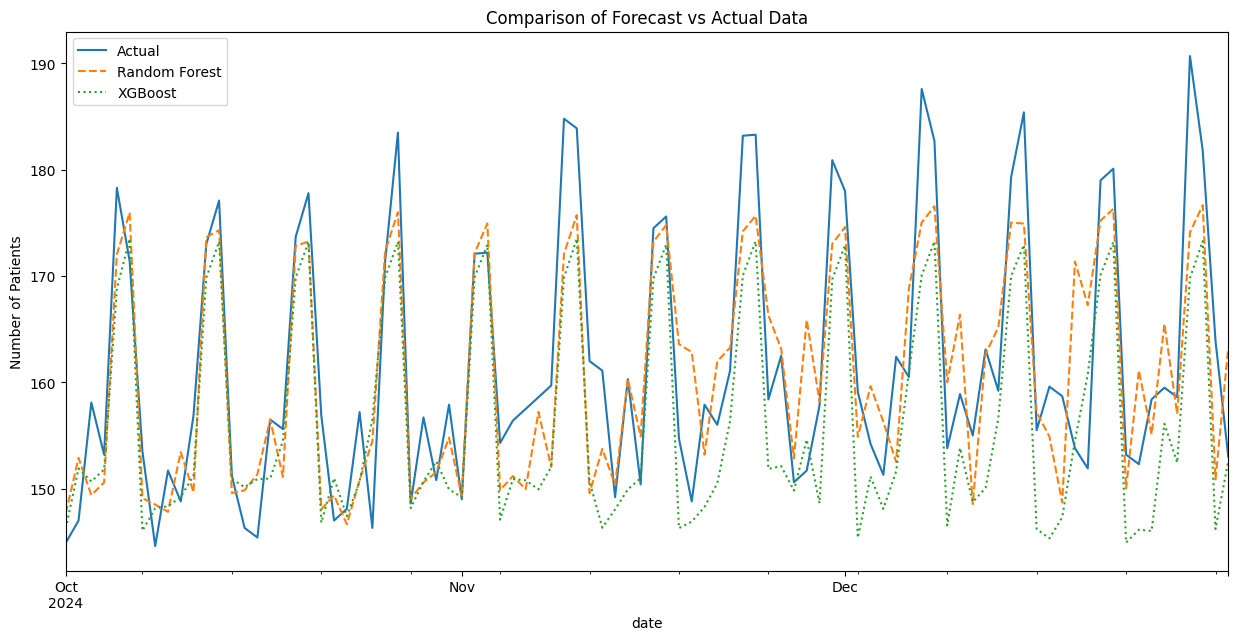

In [29]:
results.plot(figsize=(15, 7), style=['-', '--', ':'],
             title='Comparison of Forecast vs Actual Data')
plt.ylabel('Number of Patients')
plt.show()

In [30]:
def plot_feature_importance(model, features, model_name):
    # สร้าง DataFrame ของ feature importance
    fi = pd.DataFrame(data=model.feature_importances_,
                      index=features,
                      columns=['importance'])
    fi_sorted = fi.sort_values('importance', ascending=False)

    plt.figure(figsize=(10, 6))
    sns.barplot(x=fi_sorted.index, y=fi_sorted['importance'])
    plt.title(f'Feature Importance of the {model_name} Model') # Changed title to English
    plt.xticks(rotation=45)
    plt.xlabel('Features') # Added x-axis label
    plt.show()

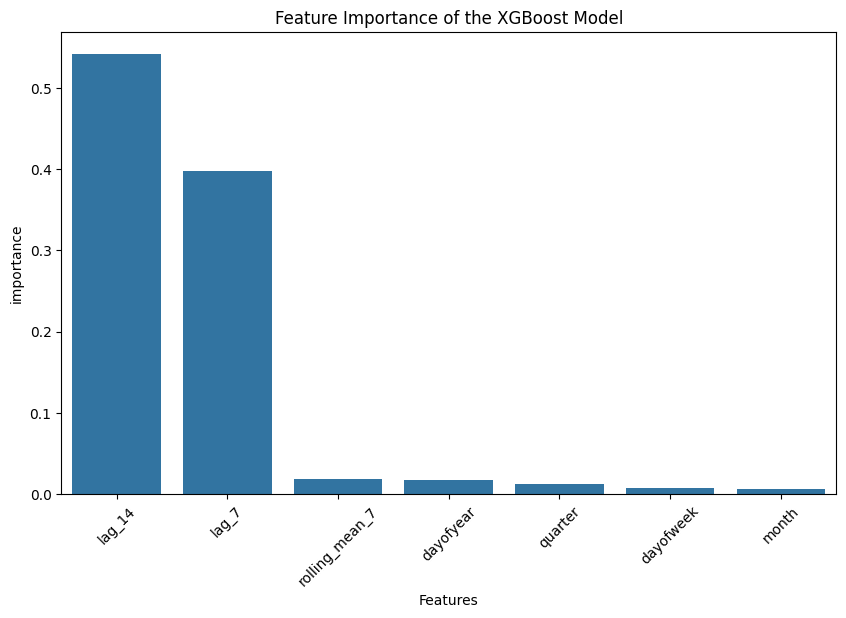

In [31]:
plot_feature_importance(xgb_model, FEATURES, 'XGBoost')

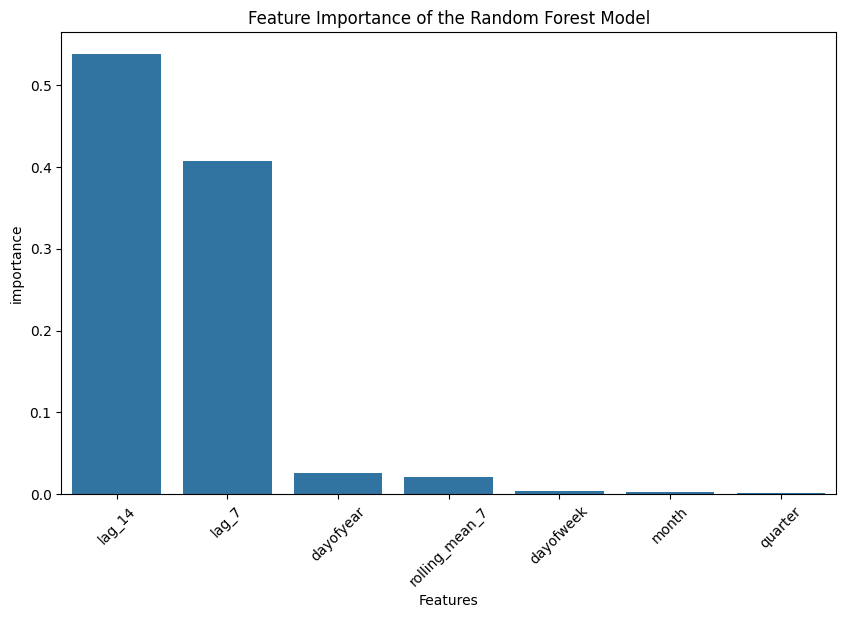

In [32]:
plot_feature_importance(rf_model, FEATURES, 'Random Forest')